In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [3]:
import pandas as pd
from sqlalchemy import create_engine

# # Database connection
engine = create_engine('sqlite:///titanic.db')

# Load datasets
train_df = pd.read_csv('train.csv')

test_df = pd.read_csv('test.csv')

# # Save to SQL database
train_df.to_sql('train', con=engine, index=False, if_exists='replace')
test_df.to_sql('test', con=engine, index=False, if_exists='replace')

# print("Data loaded and saved to SQL database.")

In [17]:
# Create an SQLite engine
engine = create_engine('sqlite:///titanic.db')

# Extract data from SQL database
train_query = "SELECT * FROM train"
test_query = "SELECT * FROM test"

train_df = pd.read_sql(train_query, engine)
test_df = pd.read_sql(test_query, engine)


Missing values in Cabin: 687 out of 891 (77.10%)


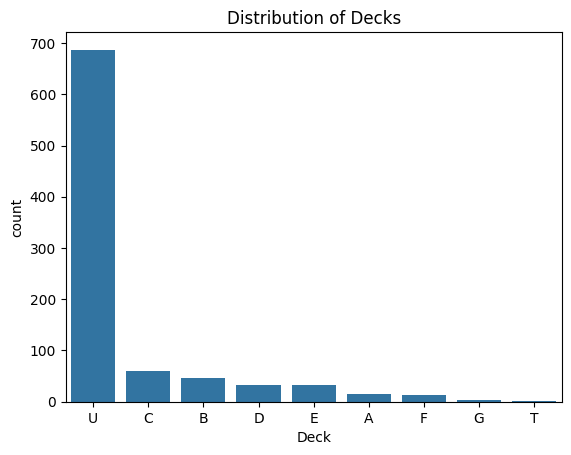

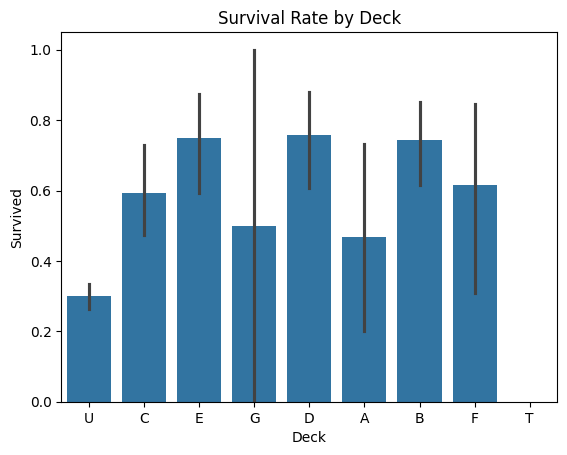

Deck
A    0.466667
B    0.744681
C    0.593220
D    0.757576
E    0.750000
F    0.615385
G    0.500000
T    0.000000
U    0.299854
Name: Survived, dtype: float64


In [21]:
# Ensure 'Embarked' column is of type string
train_df['Embarked'] = train_df['Embarked'].astype(str)
test_df['Embarked'] = test_df['Embarked'].astype(str)

# Analyze missing values in the 'Cabin' feature
missing_cabin = train_df['Cabin'].isnull().sum()
total_cabin = train_df.shape[0]
missing_percentage = missing_cabin / total_cabin * 100
print(f'Missing values in Cabin: {missing_cabin} out of {total_cabin} ({missing_percentage:.2f}%)')

# Extract the deck information from the 'Cabin' feature
train_df['Deck'] = train_df['Cabin'].str[0]
test_df['Deck'] = test_df['Cabin'].str[0]

# Fill missing 'Deck' values with a placeholder
train_df['Deck'] = train_df['Deck'].fillna('U')  # U for Unknown
test_df['Deck'] = test_df['Deck'].fillna('U')

# Visualize the distribution of Decks
sns.countplot(x='Deck', data=train_df, order=train_df['Deck'].value_counts().index)
plt.title('Distribution of Decks')
plt.show()

# Check correlation with survival
sns.barplot(x='Deck', y='Survived', data=train_df)
plt.title('Survival Rate by Deck')
plt.show()

# Check the survival rate by Deck
survival_by_deck = train_df.groupby('Deck')['Survived'].mean()
print(survival_by_deck)

# Impute missing 'Age' values with the median
age_imputer = SimpleImputer(strategy='median')
train_df['Age'] = age_imputer.fit_transform(train_df[['Age']])
test_df['Age'] = age_imputer.transform(test_df[['Age']])

# Impute missing 'Embarked' values with the most frequent value
embarked_imputer = SimpleImputer(strategy='most_frequent')
train_df['Embarked'] = embarked_imputer.fit_transform(train_df[['Embarked']].values).ravel()
test_df['Embarked'] = embarked_imputer.transform(test_df[['Embarked']].values).ravel()

# Impute missing 'Fare' values with the median (only in test set)
fare_imputer = SimpleImputer(strategy='median')
test_df['Fare'] = fare_imputer.fit_transform(test_df[['Fare']])


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [24]:
# Include 'Deck' in the list of categorical features
categorical_features = ['Pclass', 'Sex', 'Embarked', 'Deck']
numerical_features = ['Age', 'Fare', 'SibSp', 'Parch']

# OneHotEncoder for categorical features
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# StandardScaler for numerical features
numerical_transformer = StandardScaler()

# ColumnTransformer to apply the transformers to the respective features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


# Prepare the data for training
X = train_df.drop(columns=['Survived', 'Name', 'Ticket', 'Cabin'])
y = train_df['Survived']
X_test = test_df.drop(columns=['Name', 'Ticket', 'Cabin'])

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline for Elastic Net Logistic Regression
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegressionCV(cv=5, penalty='elasticnet', solver='saga', l1_ratios=[0.5]))
])

# Train the model
logreg_pipeline.fit(X_train, y_train)

# Validate the model
y_val_pred_logreg = logreg_pipeline.predict(X_val)
logreg_val_accuracy = accuracy_score(y_val, y_val_pred_logreg)
print(f'Elastic Net Logistic Regression Validation Accuracy: {logreg_val_accuracy * 100:.2f}%')

# Test the model
y_test_pred_logreg = logreg_pipeline.predict(X_test)
# Assuming you have the true labels for y_test
# logreg_test_accuracy = accuracy_score(y_test, y_test_pred_logreg)
# print(f'Elastic Net Logistic Regression Test Accuracy: {logreg_test_accuracy * 100:.2f}%')

# Create a pipeline for Neural Network
nn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000))
])

# Train the model
nn_pipeline.fit(X_train, y_train)

# Validate the model
y_val_pred_nn = nn_pipeline.predict(X_val)
nn_val_accuracy = accuracy_score(y_val, y_val_pred_nn)
print(f'Neural Network Validation Accuracy: {nn_val_accuracy * 100:.2f}%')

# Test the model
y_test_pred_nn = nn_pipeline.predict(X_test)
# nn_test_accuracy = accuracy_score(y_test, y_test_pred_nn)
# print(f'Neural Network Test Accuracy: {nn_test_accuracy * 100:.2f}%')

# Create a pipeline for SVM
svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='linear'))
])

# Train the model
svm_pipeline.fit(X_train, y_train)

# Validate the model
y_val_pred_svm = svm_pipeline.predict(X_val)
svm_val_accuracy = accuracy_score(y_val, y_val_pred_svm)
print(f'Support Vector Machine Validation Accuracy: {svm_val_accuracy * 100:.2f}%')

# Test the model
y_test_pred_svm = svm_pipeline.predict(X_test)
# svm_test_accuracy = accuracy_score(y_test, y_test_pred_svm)
# print(f'Support Vector Machine Test Accuracy: {svm_test_accuracy * 100:.2f}%')

# Create a pipeline for Random Forest
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100))
])

# Train the model
rf_pipeline.fit(X_train, y_train)

# Validate the model
y_val_pred_rf = rf_pipeline.predict(X_val)
rf_val_accuracy = accuracy_score(y_val, y_val_pred_rf)
print(f'Random Forest Validation Accuracy: {rf_val_accuracy * 100:.2f}%')

# Test the model
y_test_pred_rf = rf_pipeline.predict(X_test)
# rf_test_accuracy = accuracy_score(y_test, y_test_pred_rf)
# print(f'Random Forest Test Accuracy: {rf_test_accuracy * 100:.2f}%')

# Assuming you have the true labels for y_test, uncomment the lines above and use them to compute accuracy


c:\Users\rohan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\rohan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\rohan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\rohan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\rohan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the 

Elastic Net Logistic Regression Validation Accuracy: 81.01%
Neural Network Validation Accuracy: 81.56%
Support Vector Machine Validation Accuracy: 79.33%
Random Forest Validation Accuracy: 78.21%
